In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import seaborn as sns
import pandas as pd

from pathlib import Path
import random
import math
from copy import deepcopy
import shutil
from collections import defaultdict

from src.visualise.plot import plot_data, plot_data_simple
from src.data.paths import project_dir
from src.data.analysis import Circle, create_circular_mask, read_tiff_img
from src.data.detector import find_circle_hough_method, img_for_circle_detection, DetectorDataCollection, DetectorData, DetectorImage, center_of_mass_det

# Data loading

## Paths

In [2]:
# local paths
#base_path = project_dir / 'data' / 'raw'
base_path = Path.home() / 'OneDrive - ifj.edu.pl' / 'Projects' / 'MB_foils'

base_path.exists()

True

In [3]:
proton_path = base_path / '2025-03-27' / 'PB'
proton_path.exists()

True

In [4]:
co60_path = base_path / '2025-03-18'
co60_path.exists()

True

In [5]:
bg_path = base_path / '2025-03-27' / 'tlo2'
bg_path.exists()

True

In [6]:
base_output_path =  base_path / '2025_march_experiment' / 'analysis' / 'interim' / '2025-03-27'  # OneDrive

proton_output_path = base_output_path / 'protons'
co60_output_path = base_output_path / 'Co60'
bg_output_path = base_output_path / 'background'

# remove base output path
shutil.rmtree(base_output_path, ignore_errors=True)

# create output paths
proton_output_path.mkdir(parents=True, exist_ok=True)
co60_output_path.mkdir(parents=True, exist_ok=True)
bg_output_path.mkdir(parents=True, exist_ok=True)

print(f"created {proton_output_path}")

created C:\Users\Legion\OneDrive - ifj.edu.pl\Projects\MB_foils\2025_march_experiment\analysis\interim\2025-03-27\protons


## Data structures

In [7]:
proton_raw_data = DetectorDataCollection(path=proton_path)

10 11 12 13 14 15 16 17 18 19 1 20 21 22 23 24 25 26 27 28 29 2 30 31 32 33 34 35 36 37 38 39 3 40 4 5 6 7 8 9 

In [8]:

co60_raw_data = DetectorDataCollection(path=co60_path)

85 86 87 88 89 89 

In [9]:
bg_raw_det_path = next(bg_path.glob('**/*tif'))
bg_raw_det_image = DetectorImage(path=bg_raw_det_path, image=read_tiff_img(bg_raw_det_path, border_px=0))
bg_lv_det_path = next(bg_path.with_name(bg_path.name + '_lv').glob('**/*tif'))
bg_lv_det_image = DetectorImage(path=bg_lv_det_path, image=read_tiff_img(bg_lv_det_path, border_px=0))
bg_det_data = DetectorData(raw=bg_raw_det_image, lv=bg_lv_det_image, det_no=-1)

bg_raw_data = DetectorDataCollection(path=bg_path, data={-1: bg_det_data})

# Proton raw data

In [10]:
proton_det_id = list(proton_raw_data.data.keys())[0]
proton_det_id

10

In [11]:
from matplotlib.colors import LinearSegmentedColormap


def plot_lv_raw_and_histograms(
        lv_image: np.ndarray,
        raw_data: np.ndarray,
        title: str = None,
):
        # Create a custom colormap
        colors = [(1, 1, 1), (0, 1, 0), (1, 0, 0)]  # white -> green -> red
        n_bins = 100  # Number of bins
        cmap_name = 'custom_cmap'
        custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

        clip_percentile: float = 99
        strip_width = 100
        gaussian_kernel_size = 3

        # lv_image = proton_raw_data.data[proton_det_id].lv.image.copy()
        lv_image_strip = np.concatenate([
                lv_image[:, :strip_width].flatten(), 
                lv_image[:, -strip_width:].flatten(),
                lv_image[:strip_width, :].flatten(),
                lv_image[-strip_width:, :].flatten()
        ]).flatten()

        lv_mean_noise = np.mean(lv_image_strip)
        lv_sigma_noise = np.std(lv_image_strip)
        lv_upper_limit = np.percentile(lv_image, clip_percentile)


        lv_smoothed_image = ndi.gaussian_filter(lv_image, sigma=gaussian_kernel_size)

        detector_mask = lv_smoothed_image > lv_mean_noise + 3 * lv_sigma_noise

        lv_smoothed_image[~detector_mask] = 0

        # raw_data = proton_raw_data.data[proton_det_id].raw.image.copy()
        raw_image_strip = np.concatenate([
                raw_data[:, :strip_width].flatten(),
                raw_data[:, -strip_width:].flatten(),
                raw_data[:strip_width, :].flatten(),
                raw_data[-strip_width:, :].flatten()
        ]).flatten()

        raw_mean_noise = np.mean(raw_image_strip)
        raw_sigma_noise = np.std(raw_image_strip)
        raw_upper_limit = np.percentile(raw_data, clip_percentile)

        raw_smoothed_image = ndi.gaussian_filter(raw_data, sigma=gaussian_kernel_size)
        raw_smoothed_image[~detector_mask] = 0

        fig, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0,0].hist(lv_image.flatten(), 
                bins=100, 
                range=(0, lv_upper_limit),
                density=True,
                histtype='step',
                label='all data');
        ax[0,0].axvline(lv_mean_noise, color='r', linestyle='--', label='mean noise')
        ax[0,0].axvline(lv_mean_noise + 3 * lv_sigma_noise, color='g', linestyle='--', label='mean noise + 3 sigma')
        ax[0,0].set_yscale('log')
        ax[0,0].legend()
        ax[0,0].grid()
        ax[0,0].set_xlim(0, None)

        ax[1,0].hist(raw_data.flatten(),
                bins=100, 
                range=(0, raw_upper_limit),
                density=True,
                histtype='step',
                label='all data');
        ax[1,0].axvline(raw_mean_noise, color='r', linestyle='--', label='mean noise')
        ax[1,0].axvline(raw_mean_noise + 3 * raw_sigma_noise, color='g', linestyle='--', label='mean noise + 3 sigma')
        ax[1,0].set_yscale('log')
        ax[1,0].legend()
        ax[1,0].grid()
        ax[1,0].set_xlim(0, None)


        pos = ax[0,1].imshow(lv_smoothed_image[300:700, 300:700], 
                        cmap=custom_cmap, 
                        vmin=lv_mean_noise, 
                        vmax=lv_upper_limit)
        ax[0,1].grid()
        plt.colorbar(pos, ax=ax[0,1], shrink=0.8, pad=0.01)
        ax[0,1].set_title('lv image')

        pos = ax[1,1].imshow(raw_smoothed_image[300:700, 300:700],
                        cmap=custom_cmap, 
                        vmin=0, 
                        vmax=raw_upper_limit)
        ax[1,1].grid()
        plt.colorbar(pos, ax=ax[1,1], shrink=0.8, pad=0.01)
        ax[1,1].set_title('raw image')

        fig.suptitle(title, fontsize=16)

        fig.tight_layout();

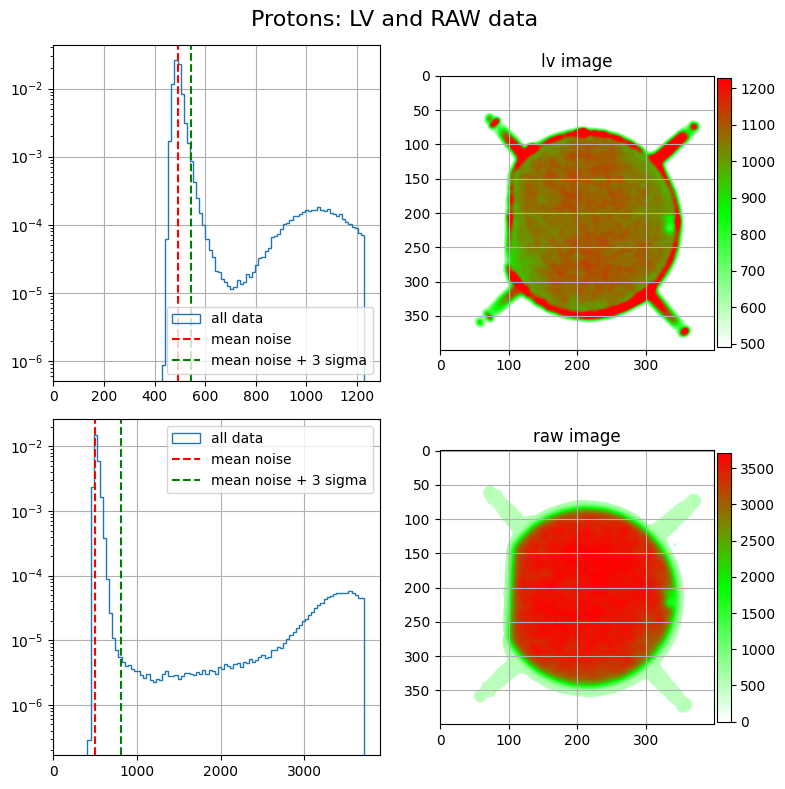

In [12]:
plot_lv_raw_and_histograms(
        lv_image=proton_raw_data.data[proton_det_id].lv.image.copy(),
        raw_data=proton_raw_data.data[proton_det_id].raw.image.copy(),
        title='Protons: LV and RAW data',
)

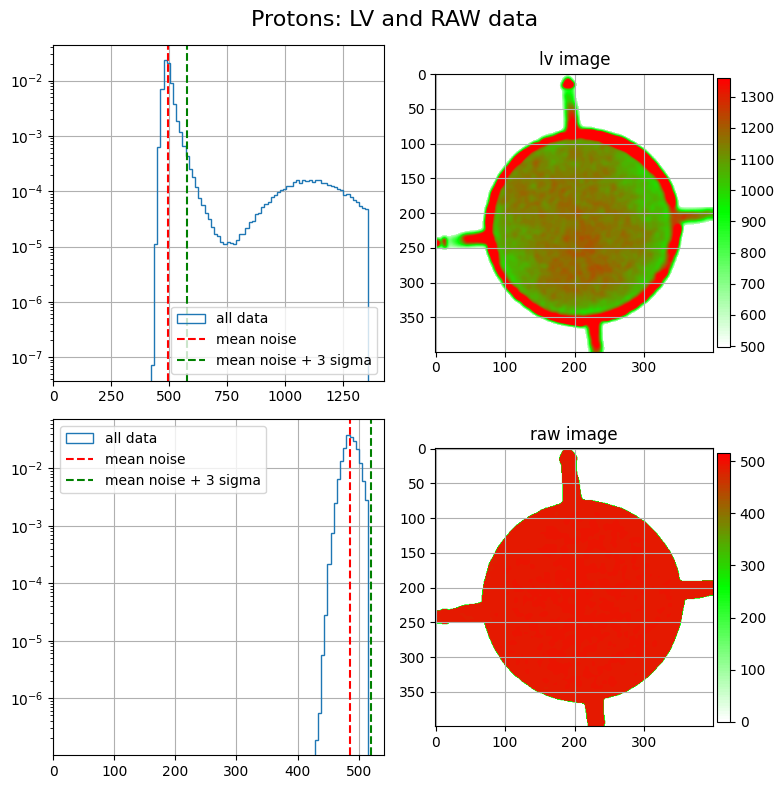

In [13]:
plot_lv_raw_and_histograms(
        lv_image=bg_det_data.lv.image.copy(),
        raw_data=bg_det_data.raw.image.copy(),
        title='Protons: LV and RAW data',
)

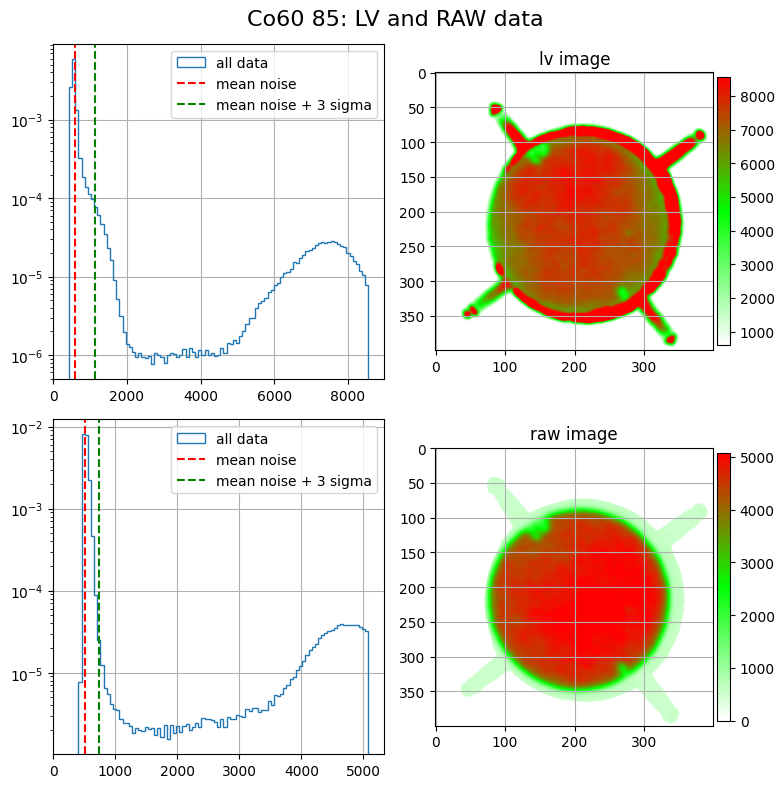

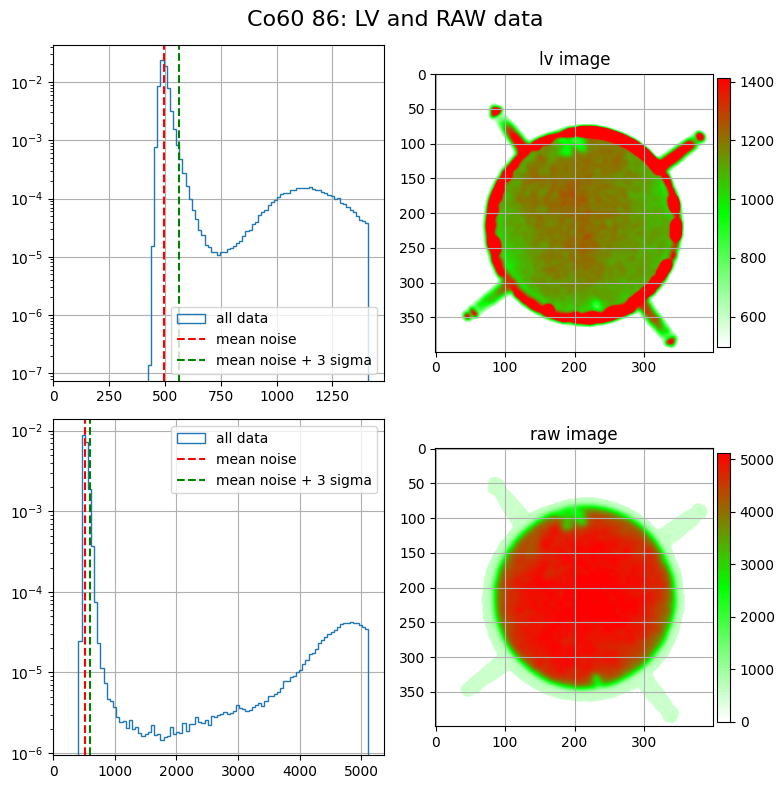

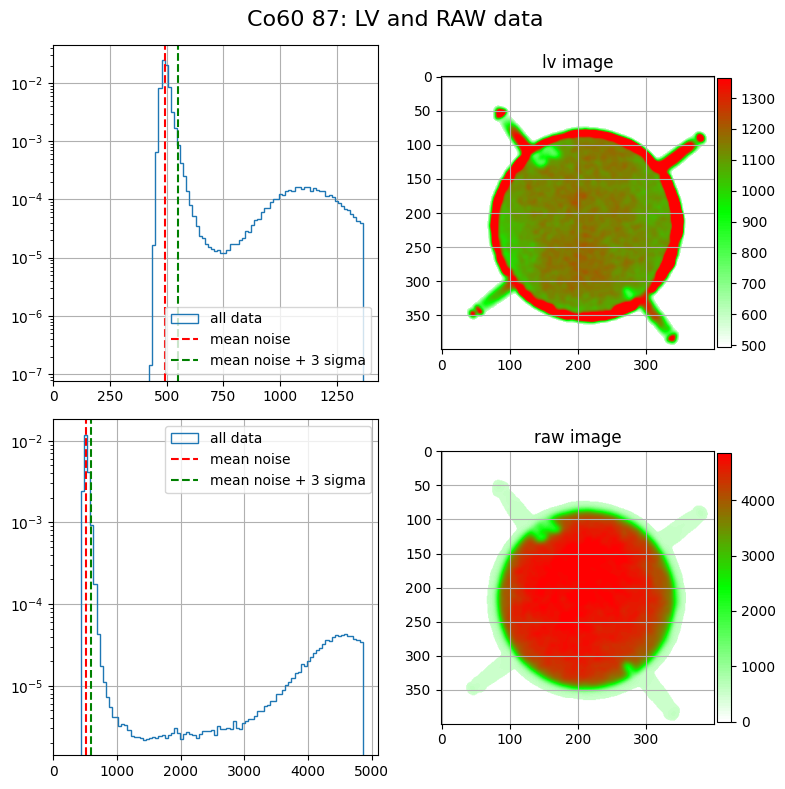

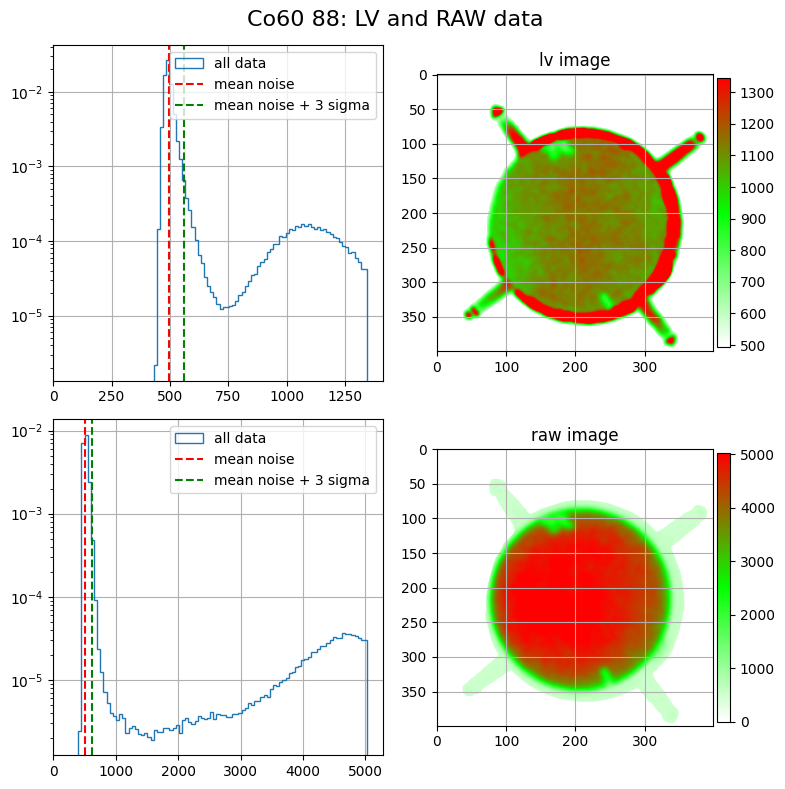

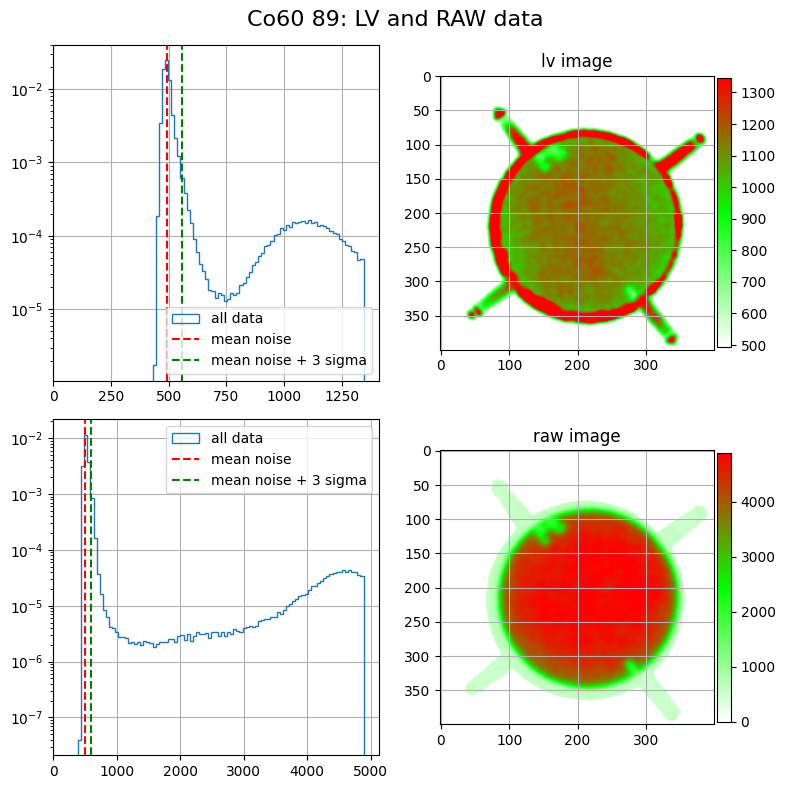

In [14]:
for co60_det_id in co60_raw_data.data.keys():
    plot_lv_raw_and_histograms(
        lv_image=co60_raw_data.data[co60_det_id].lv.image.copy(),
        raw_data=co60_raw_data.data[co60_det_id].raw.image.copy(),
        title=f'Co60 {co60_det_id}: LV and RAW data',
    )

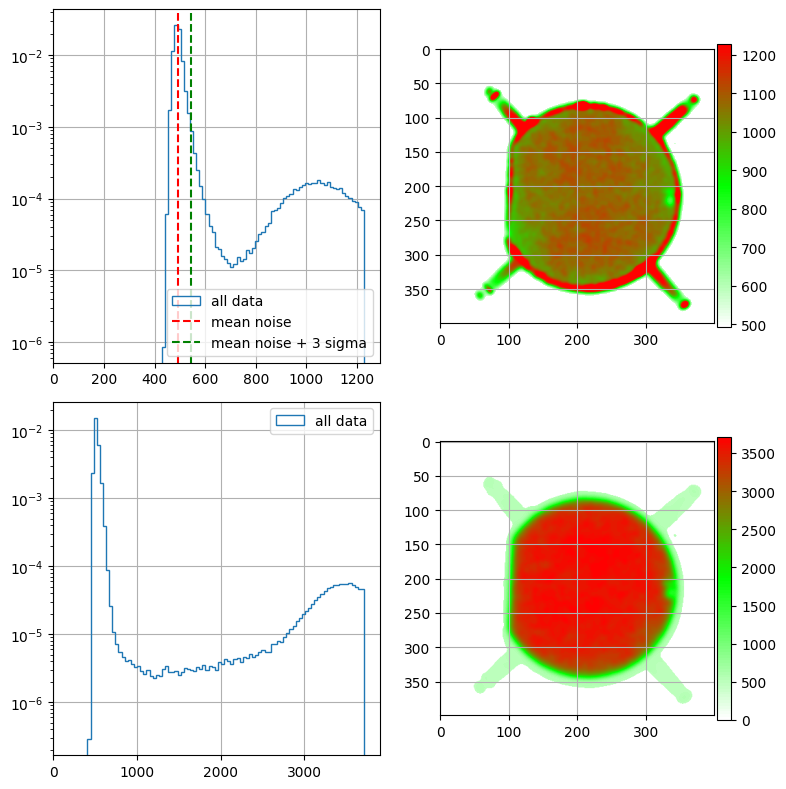

In [15]:
# Create a custom colormap
colors = [(1, 1, 1), (0, 1, 0), (1, 0, 0)]  # white -> green -> red
n_bins = 100  # Number of bins
cmap_name = 'custom_cmap'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

clip_percentile: float = 99
strip_width = 100
gaussian_kernel_size = 3

lv_image = proton_raw_data.data[proton_det_id].lv.image.copy()
lv_image_strip = np.concatenate([
    lv_image[:, :strip_width].flatten(), 
    lv_image[:, -strip_width:].flatten(),
    lv_image[:strip_width, :].flatten(),
    lv_image[-strip_width:, :].flatten()
]).flatten()

lv_mean_noise = np.mean(lv_image_strip)
lv_sigma_noise = np.std(lv_image_strip)
lv_upper_limit = np.percentile(lv_image, clip_percentile)


lv_smoothed_image = ndi.gaussian_filter(lv_image, sigma=gaussian_kernel_size)

detector_mask = lv_smoothed_image > lv_mean_noise + 3 * lv_sigma_noise

lv_smoothed_image[~detector_mask] = 0

raw_data = proton_raw_data.data[proton_det_id].raw.image.copy()
raw_image_strip = np.concatenate([
    raw_data[:, :strip_width].flatten(),
    raw_data[:, -strip_width:].flatten(),
    raw_data[:strip_width, :].flatten(),
    raw_data[-strip_width:, :].flatten()
]).flatten()

raw_mean_noise = np.mean(raw_image_strip)
raw_sigma_noise = np.std(raw_image_strip)
raw_upper_limit = np.percentile(raw_data, clip_percentile)

raw_smoothed_image = ndi.gaussian_filter(raw_data, sigma=gaussian_kernel_size)
raw_smoothed_image[~detector_mask] = 0

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

ax[0,0].hist(lv_image.flatten(), 
           bins=100, 
           range=(0, lv_upper_limit),
           density=True,
           histtype='step',
           label='all data');
ax[0,0].axvline(lv_mean_noise, color='r', linestyle='--', label='mean noise')
ax[0,0].axvline(lv_mean_noise + 3 * lv_sigma_noise, color='g', linestyle='--', label='mean noise + 3 sigma')
ax[0,0].set_yscale('log')
ax[0,0].legend()
ax[0,0].grid()
ax[0,0].set_xlim(0, None)

ax[1,0].hist(raw_data.flatten(),
           bins=100, 
           range=(0, np.percentile(raw_data.flatten(), clip_percentile)),
           density=True,
           histtype='step',
           label='all data');
ax[1,0].set_yscale('log')
ax[1,0].legend()
ax[1,0].grid()
ax[1,0].set_xlim(0, None)


pos = ax[0,1].imshow(lv_smoothed_image[300:700, 300:700], 
                   cmap=custom_cmap, 
                   vmin=lv_mean_noise, 
                   vmax=lv_upper_limit)
ax[0,1].grid()
plt.colorbar(pos, ax=ax[0,1], shrink=0.8, pad=0.01)

pos = ax[1,1].imshow(raw_smoothed_image[300:700, 300:700],
                   cmap=custom_cmap, 
                   vmin=0, 
                   vmax=raw_upper_limit)
ax[1,1].grid()
plt.colorbar(pos, ax=ax[1,1], shrink=0.8, pad=0.01)

fig.tight_layout();